In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

dir = '/Users/mrefermat/git/FinancePhD/Empirical Methods/Homework2/'

file1 = 'CRSPzero_yields.xls'
file2 = 'GDPC1.xls'
file3 = 'Factors(1).xlsx'
file4 = 'FoF.xlsx'
file5 = 'tbill.csv'

Populating the interactive namespace from numpy and matplotlib


In [2]:
tbill=pd.read_csv(dir+file5,parse_dates=0,index_col=0).resample(rule='m',how='last')
factors=pd.read_excel(dir+file3,parse_dates=0,header=4,index_col=0).resample(rule='m',how='last')
FoF=pd.read_excel(dir+file4,parse_dates=0,index_col=0).resample(rule='m',how='last')

Since we use excess returns in the regression, we need to take away 30 day cash returns.

In [3]:
FoF=FoF-tbill.t30ret*100

/Users/mrefermat/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


To calculate $\alpha$ for each fund and it's relevent t-stat, I use the benhcmakr model of Fung and Hsieh (RFS, 2001):

$$ rexc_{i,t} = \alpha_i + \beta_i^1SNPexc_t+B_i^2SML_t+\beta_i^3MSCIem_t + \beta_i^4RBD10_t + \beta_+i^5BAAMBD10_t + \beta_i^6PTFSBD_t + \beta_i^7PTFSFX_t + \beta_i^8PTFSCOM_t + \varepsilon_{i,t} $$

I selected funds with only five years of fund performance in line with BSW for two reasons.  First to match exactly their procedure, but secondly because 5 years allows for the fund to see many different types of market environments.  I don't want to select funds just because they happen to launch at the right time.  Of the FoF list of 6392 names I only get 3101 with at least 5 yeras of data (continous or not).

In [113]:
beta=pd.DataFrame()
t_stats=pd.DataFrame()
p_values=pd.DataFrame()
r2= pd.Series()
for f in FoF.columns:
    df = pd.DataFrame()
    df['Fund']=FoF[f].dropna()
    if df.Fund.count() < 60:
        continue
    df=pd.concat([df,factors],axis=1, join='inner')
    df['Alpha']=1
    cols= factors.columns.tolist()
    cols.append('Alpha')
    res = sm.OLS(df.Fund,df[cols]).fit()
    beta[f]=res.params
    t_stats[f]=res.tvalues
    p_values[f]=res.pvalues
    r2[f]=res.rsquared_adj

In [97]:
beta.T.describe().Alpha

count    3101.000000
mean       -0.010674
std         0.491618
min        -5.595318
25%        -0.232083
50%        -0.045830
75%         0.166323
max         2.962789
Name: Alpha, dtype: float64

In [114]:
t_stats.T.skew()

Equity market factor      3.136246
Size Spread factor        1.293599
Bond market factor       -0.062623
Credit Spread factor     -0.614855
PTFSBD                    0.061951
PTFSFX                    0.450354
PTFSCOM                   0.259602
Emerging Market factor    0.319807
Alpha                     4.353978
dtype: float64

In [94]:
r2.describe()

count    3101.000000
mean        0.422063
std         0.215852
min        -0.093906
25%         0.264733
50%         0.445326
75%         0.586152
max         0.982809
dtype: float64

# $\alpha$ and T stat distribution

Note how high some of the alpha terms are

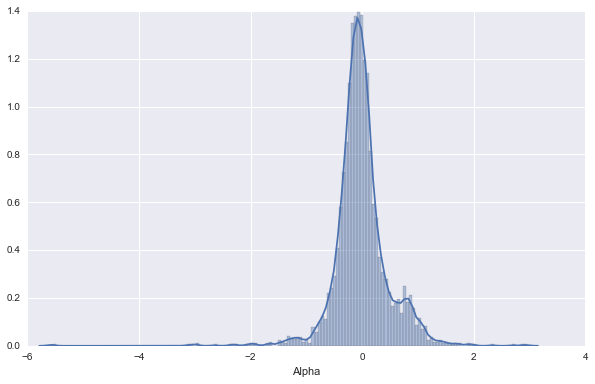

In [7]:
sns.distplot(beta.T.Alpha)

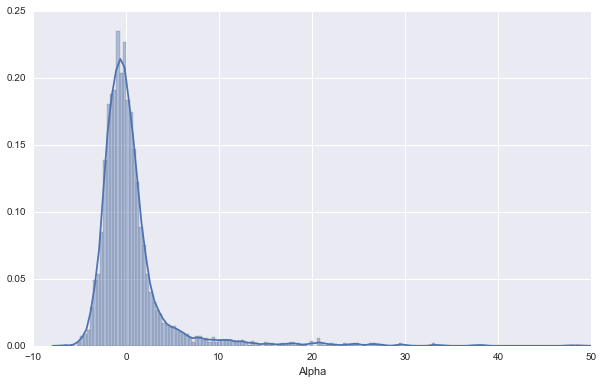

In [8]:
sns.distplot(t_stats.T.Alpha)

# Calculating $\hat{\pi_0}$ from p values

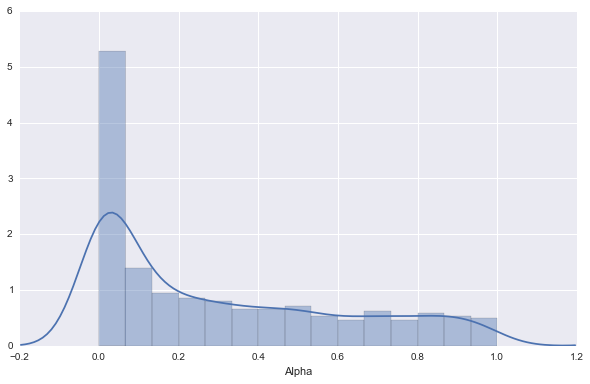

In [9]:
sns.distplot(p_values.T.Alpha)

To estimate $\pi_0$, we need to pick an threshold, $\lambda_0$, and then work out the proportion of funds that above the threshold.  The formula for calculting $\hat{\pi_0}$ is:

$$ \hat{\pi_0} = \frac{\hat{W}(\lambda^*)}{M} \frac{1}{1-\lambda^*} $$

We can apply a simple bootstrap procedure to minimize the estimated mean squared error (MSE) of $\hat{\pi_0}$ in order to select the best $\lambda^*$.  Where $\hat{W}(\lambda^*)$ is the proportion with p values exceeding $\lambda^*$.

In [10]:
# Code from: http://nbviewer.jupyter.org/gist/aflaxman/6871948
# randomly resamples Series and returns it
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if isinstance(X, pd.Series):
        X = X.copy()
        X.index = range(len(X.index))
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = np.array(X[resample_i])  # TODO: write a test demonstrating why array() is important
    return X_resample


First calcuate $\hat{\pi_0}$ for each value of $\lambda$ from 0.3 to 0.7 in increments of 0.05. in this equation:

$$ \hat{\pi_0} = \frac{\hat{W}(\lambda^*)}{M} \frac{1}{1-\lambda^*} $$

In [11]:
# Calculating lambda * and pi hat using bootstraping 
pv=p_values.T.Alpha
min_pi_hat=1
for lamb in [x / 100. for x in range(30,75,5)]:
    if min_pi_hat > pv[pv>lamb].count() / float(pv.count()) * 1/(1-lamb):
        min_pi_hat = pv[pv>lamb].count() / float(pv.count()) * 1/(1-lamb)

d={}
for lamb in [x / 100. for x in range(30,75,5)]:
    l=[]
    for x in range(0,1000):
        bsr = bootstrap_resample(pv)
        l.append(((bsr>lamb).sum() / float(len(bsr)) * 1/(1-lamb)-min_pi_hat)**2)
    d[lamb]=np.mean(l)
lambda_star=min(d, key=d.get)
print 'Lambda*: '+ str(lambda_star)
# Calculating pi hat using lambda *
pi_hat = pv[pv>lambda_star].count() / float(pv.count()) * 1/(1-lambda_star)
print 'Pi_0^hat: '+ str(pi_hat)

Lambda*: 0.55
Pi_0^hat: 0.524561969257


# Calculating  $\hat{\pi_A^+}$ and $\hat{\pi_A^-}$ 

To determine the value for $\hat{\pi_A^+}$ and $\hat{\pi_A^-}$ we use a boostrap proceedure that minimizes the estimated MSE.  First off the formula we are trying to find is:

$$ \hat{\pi_A^+} = \hat{T}_{\gamma^*}^+ = \hat{S}_{\gamma^*}^+ - \hat{F}_{\gamma^*}^+ = \hat{S}_{\gamma^*}^+ - \hat{\pi}_0*\frac{{\gamma^*}}{2} $$

$$ \hat{\pi_A^-} = \hat{T}_{\gamma^*}^- = \hat{S}_{\gamma^*}^- - \hat{F}_{\gamma^*}^- = \hat{S}_{\gamma^*}^- - \hat{\pi}_0*\frac{{\gamma^*}}{2} $$

Where $S$ is the proportion of significant funds above a threshold of $\gamma^*$ and $F$ is the proportion of lucky or unlucky funds that are miscatogorized as per Storey (2002). Lastly, $T$ is the proportion of adjusted funds.  In order to find $\gamma^*$, we use bootstrapping techniques to minimizes the estimated MSE of $\hat{\pi_A^-}(\gamma)$.  

$$ \hat{MSE}^-(\gamma) = \frac{1}{1000}\sum_{b=1}^{1000} \left [ \hat{\pi}_A^{b-}(\gamma) - \max_{\gamma}\hat{\pi}_A^-(\gamma) \right ]^2 $$



In [12]:
# Calculating gamma * via the bootstrapping methodology for pi_negative
alpha_t_stat=t_stats.T.Alpha
max_pi_hat=-5
for gamma in [x / 100. for x in range(1,55,5)]:
    thres = stats.t.ppf(1-(gamma/200.),999)*-1   
    signif=alpha_t_stat[alpha_t_stat<thres].count() / float(alpha_t_stat.count())
    if max_pi_hat < signif-pi_hat*gamma/2.0:
        max_pi_hat = signif-pi_hat*gamma/2.0
d={}
for gamma in [x / 100. for x in range(1,55,5)]:
    l=[]
    for x in range(0,1000):
        thres = stats.t.ppf(1-(gamma/200.),999)*-1   
        bsr = bootstrap_resample(alpha_t_stat)
        signif=len(bsr[bsr<thres]) / float(len(bsr))
        luck=pi_hat*gamma/2.0
        l.append((signif-luck) **2)
    d[gamma]=np.mean(l)
gamma_star=min(d, key=d.get)
print 'Gamma*: '+ str(gamma_star)
# Calculating pi hat_negative using gamma *
thres = stats.t.ppf(1-(gamma_star/200.),999)*-1 
pi_hat_neg=alpha_t_stat[alpha_t_stat<thres].count() / float(alpha_t_stat.count())- pi_hat*gamma_star/2.0
print 'Pi_0^hat_neg: '+ str(pi_hat_neg)



Gamma*: 0.11
Pi_0^hat_neg: 0.00275180049446


In [13]:
# Calculating gamma * via the bootstrapping methodology for pi_positive
alpha_t_stat=t_stats.T.Alpha
max_pi_hat=-5
for gamma in [x / 100. for x in range(1,55,5)]:
    thres = stats.t.ppf(1-(gamma/200.),999)   
    signif=alpha_t_stat[alpha_t_stat>thres].count() / float(alpha_t_stat.count())
    if max_pi_hat < signif-pi_hat*gamma/2.0:
        max_pi_hat = signif-pi_hat*gamma/2.0
        
print max_pi_hat

d_pos={}
for gamma in [x / 100. for x in range(1,55,5)]:
    l=[]
    for x in range(0,1000):
        thres = stats.t.ppf(1-(gamma/200.),999)   
        bsr = bootstrap_resample(alpha_t_stat)
        signif=len(bsr[bsr>thres]) / float(len(bsr))
        luck=pi_hat*gamma/2.0
        l.append((signif-luck) **2)
    d_pos[gamma]=np.mean(l)
gamma_star=min(d_pos, key=d_pos.get)
print 'Gamma*: '+ str(gamma_star)
# Calculating pi hat_negative using gamma *
thres = stats.t.ppf(1-(gamma_star/200.),999)
pi_hat_pos=alpha_t_stat[alpha_t_stat>thres].count() / float(alpha_t_stat.count())- pi_hat*gamma_star/2.0
print 'Pi_0^hat_pos: '+ str(pi_hat_pos)

0.0857357841556
Gamma*: 0.46
Pi_0^hat_pos: -0.00294528646673


In [14]:
if min(d.values()) <min(d_pos.values()):
    pi_hat_pos = 1-pi_hat- pi_hat_neg
else:
    pi_hat_neg = 1-pi_hat- pi_hat_pos

print 'Pi^_0: '+ str(pi_hat*100)
print 'Pi^_pos: '+ str(pi_hat_pos*100)
print 'Pi^_neg: '+ str(pi_hat_neg*100)
    

Pi_0^hat_0: 52.4561969257
Pi_0^hat_pos: 47.2686230248
Pi_0^hat_neg: 0.275180049446


# Calculate the same data only use the last 10 years of data
Hedge fund suffered in two areas during the GFC.  First the quant crisis of August 2007 as many quant equity funds unwound their positions it caused a massive reversal.  Secondly, most hedge fund techniques did not perform too well during the financial crisis. Furthermore, assets in hedge fund strategies have grown amazingly as more and more institutional investors.  Many have reported that alpha has decade for many hedge funds.

In [98]:
beta=pd.DataFrame()
t_stats=pd.DataFrame()
p_values=pd.DataFrame()
r2= pd.Series()
for f in FoF.columns:
    df = pd.DataFrame()
    df['Fund']=FoF[f].dropna()['2005':]
    if df.Fund.count() < 60:
        continue
    df=pd.concat([df,factors],axis=1, join='inner')
    df['Alpha']=1
    cols= factors.columns.tolist()
    cols.append('Alpha')
    res = sm.OLS(df.Fund,df[cols]).fit()
    beta[f]=res.params
    t_stats[f]=res.tvalues
    p_values[f]=res.pvalues
    r2[f]=res.rsquared

In [104]:
beta.T.kurtosis()

Equity market factor      25.657959
Size Spread factor        24.526032
Bond market factor        16.420453
Credit Spread factor      15.366180
PTFSBD                    28.861130
PTFSFX                    36.546643
PTFSCOM                   59.985627
Emerging Market factor    10.184094
Alpha                     19.267995
dtype: float64

In [106]:
t_stats.T.kurtosis()

Equity market factor      45.264317
Size Spread factor         0.727553
Bond market factor         0.088622
Credit Spread factor      -0.000902
PTFSBD                     0.659670
PTFSFX                     0.743417
PTFSCOM                    0.197999
Emerging Market factor     1.448815
Alpha                     24.560293
dtype: float64

In [112]:
p_values.T.std()

Equity market factor      0.297018
Size Spread factor        0.286766
Bond market factor        0.290345
Credit Spread factor      0.301165
PTFSBD                    0.292866
PTFSFX                    0.276339
PTFSCOM                   0.299046
Emerging Market factor    0.173818
Alpha                     0.306960
dtype: float64

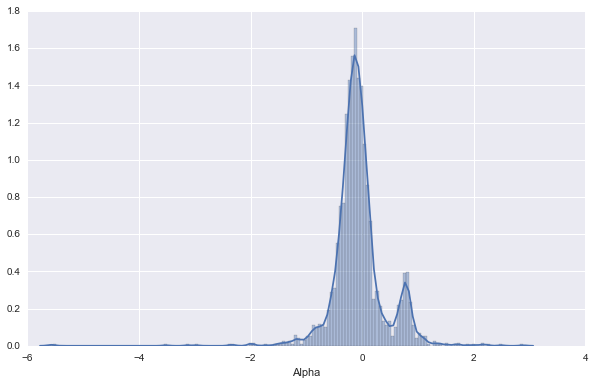

In [19]:
sns.distplot(beta.T.Alpha)

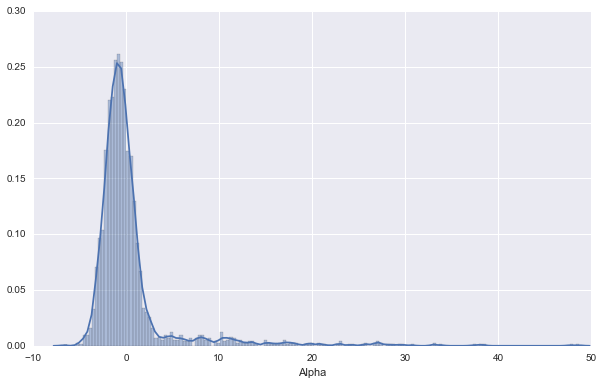

In [20]:
sns.distplot(t_stats.T.Alpha)

In [21]:
# Calculating lambda * and pi hat using bootstraping 
pv=p_values.T.Alpha
min_pi_hat=1
for lamb in [x / 100. for x in range(30,75,5)]:
    if min_pi_hat > pv[pv>lamb].count() / float(pv.count()) * 1/(1-lamb):
        min_pi_hat = pv[pv>lamb].count() / float(pv.count()) * 1/(1-lamb)

d={}
for lamb in [x / 100. for x in range(30,75,5)]:
    l=[]
    for x in range(0,1000):
        bsr = bootstrap_resample(pv)
        l.append(((bsr>lamb).sum() / float(len(bsr)) * 1/(1-lamb)-min_pi_hat)**2)
    d[lamb]=np.mean(l)
lambda_star=min(d, key=d.get)
print 'Lambda*: '+ str(lambda_star)
# Calculating pi hat using lambda *
pi_hat = pv[pv>lambda_star].count() / float(pv.count()) * 1/(1-lambda_star)
print 'Pi_0^hat: '+ str(pi_hat)

Lambda*: 0.65
Pi_0^hat: 0.536939055458


In [22]:
# Calculating gamma * via the bootstrapping methodology for pi_negative
alpha_t_stat=t_stats.T.Alpha
max_pi_hat=-5
for gamma in [x / 100. for x in range(1,55,5)]:
    thres = stats.t.ppf(1-(gamma/200.),999)*-1   
    signif=alpha_t_stat[alpha_t_stat<thres].count() / float(alpha_t_stat.count())
    if max_pi_hat < signif-pi_hat*gamma/2.0:
        max_pi_hat = signif-pi_hat*gamma/2.0
d={}
for gamma in [x / 100. for x in range(1,55,5)]:
    l=[]
    for x in range(0,1000):
        thres = stats.t.ppf(1-(gamma/200.),999)*-1   
        bsr = bootstrap_resample(alpha_t_stat)
        signif=len(bsr[bsr<thres]) / float(len(bsr))
        luck=pi_hat*gamma/2.0
        l.append((signif-luck) **2)
    d[gamma]=np.mean(l)
gamma_star=min(d, key=d.get)
print 'Gamma*: '+ str(gamma_star)
# Calculating pi hat_negative using gamma *
thres = stats.t.ppf(1-(gamma_star/200.),999)*-1 
pi_hat_neg=alpha_t_stat[alpha_t_stat<thres].count() / float(alpha_t_stat.count())- pi_hat*gamma_star/2.0
print 'Pi_0^hat_neg: '+ str(pi_hat_neg)

Gamma*: 0.11
Pi_0^hat_neg: -0.00163955842968


In [23]:
# Calculating gamma * via the bootstrapping methodology for pi_positive
alpha_t_stat=t_stats.T.Alpha
max_pi_hat=-5
for gamma in [x / 100. for x in range(1,55,5)]:
    thres = stats.t.ppf(1-(gamma/200.),999)   
    signif=alpha_t_stat[alpha_t_stat>thres].count() / float(alpha_t_stat.count())
    if max_pi_hat < signif-pi_hat*gamma/2.0:
        max_pi_hat = signif-pi_hat*gamma/2.0
        
print max_pi_hat

d_pos={}
for gamma in [x / 100. for x in range(1,55,5)]:
    l=[]
    for x in range(0,1000):
        thres = stats.t.ppf(1-(gamma/200.),999)   
        bsr = bootstrap_resample(alpha_t_stat)
        signif=len(bsr[bsr>thres]) / float(len(bsr))
        luck=pi_hat*gamma/2.0
        l.append((signif-luck) **2)
    d_pos[gamma]=np.mean(l)
gamma_star=min(d_pos, key=d_pos.get)
print 'Gamma*: '+ str(gamma_star)
# Calculating pi hat_negative using gamma *
thres = stats.t.ppf(1-(gamma_star/200.),999)
pi_hat_pos=alpha_t_stat[alpha_t_stat>thres].count() / float(alpha_t_stat.count())- pi_hat*gamma_star/2.0
print 'Pi_0^hat_pos: '+ str(pi_hat_pos)

0.0828205630675
Gamma*: 0.36
Pi_0^hat_pos: -0.0029133189627


In [24]:
if min(d.values()) <min(d_pos.values()):
    pi_hat_pos = 1-pi_hat- pi_hat_neg
else:
    pi_hat_neg = 1-pi_hat- pi_hat_pos

print 'Pi_0^hat_0: '+ str(pi_hat*100)
print 'Pi_0^hat_pos: '+ str(pi_hat_pos*100)
print 'Pi_0^hat_neg: '+ str(pi_hat_neg*100)

Pi_0^hat_0: 53.6939055458
Pi_0^hat_pos: 46.4700502972
Pi_0^hat_neg: -0.163955842968


Things we need to do:

Compile a table for multiple points of gamma with MSE numbers
Sensitivity to certain parameters
Ferson and Chan need to understand method and code it up
Concluding thoughts:
    Are factors really betas?
    Is alpha really alpha?
    Tstat of alpha says more about consistances than actual outperformance
    x--AHL is listed multiple times for the same fund but different currency share classes, I suspect the original data is not as clean as it could be
    FC use only 12 month window for HF which is far too short as it doesn't cover the business cycle
    Best info is how much type you should be spending on DD.  If there are not many bad funds but some zero alpha funds.
    x--Multiple share classes of same funds.  Different currency classes can have different alpha if they don't hedge
    This is only slightly relevant for FoF and not in the spirit of EDHEC RI which calls for customized investment solutions for each investor which I would agree is more inline in traditional investment theory (endogenous utility functions).
    Parsimony question
    

# Criticisms - 1 same fund different share classes

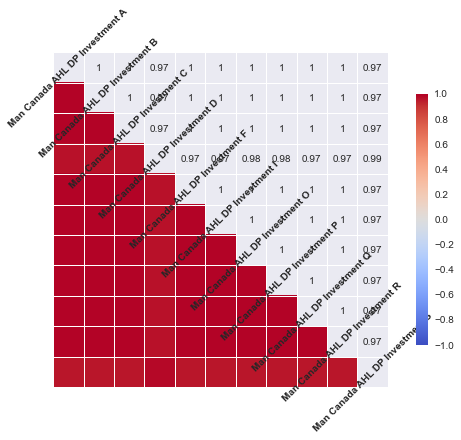

In [40]:
l=[]
for f in FoF.columns:
    if 'AHL' in f:
        if 'Canada' in f:
            if 'G' not in f:
                if 'T' not in f:
                    l.append(f)
sns.corrplot(FoF[l])

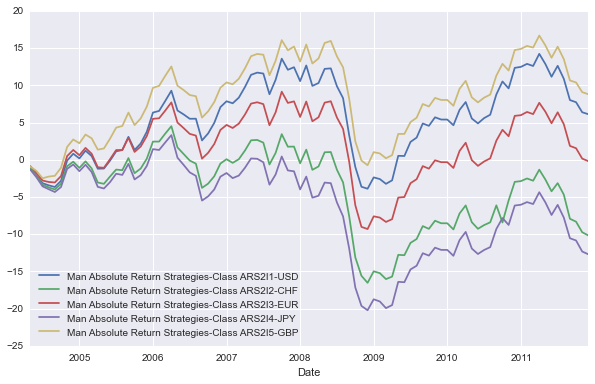

In [63]:
l=[]
for f in FoF.columns:
    if 'Man Absolute Return Strategies-Class AR' in f:
        if 'Man' in f:
            l.append(f)
FoF[l].dropna().cumsum().plot()

In [64]:
l=[]
for f in FoF.columns:
    if 'Man' in f:
        if 'IP 220' in f:
            l.append(f)
        
l

[u'Man IP 220 Series 4 Ltd EUR',
 u'Man IP 220 Series 4 Ltd USD',
 u'Man IP 220 Series 5 Ltd EUR',
 u'Man IP 220 Series 5 Ltd USD',
 u'Man-IP 220 Plus Series 4 Ltd EUR',
 u'Man-IP 220 Plus Series 4 Ltd USD']

In [45]:
FoF.columns

Index([     u'303 Equity Trading Group LLC',
                   u'303 Opportunities LLC',
                      u'3A Commodity (USD)',
              u'3A long Short Fund (EUR) C',
         u'3A Multi Arbitrage Fund (EUR) C',
          u'3A Multi Strategy Fund (CHF) C',
       u'3A Natural Resources Fund (CHF) A',
       u'3A Natural Resources Fund (CHF) B',
       u'3A Natural Resources Fund (EUR) A',
       u'3A Natural Resources Fund (EUR) B', 
       ...
                u'Zebra Multi-Strategy Ltd',
                      u'Zelis Alternatif 1',
                      u'Zelis Alternatif 2',
                      u'Zelis Alternatif 3',
                     u'Zenit European Fund',
                       u'Zenit Master Fund',
                 u'Zeus FICFI Multimercado',
                               u'Zhong Guo',
                 u'ZHV Global Balanced EUR',
                 u'ZHV Global Balanced GBP'],
      dtype='object', length=6392)